# EOF Analysis of AR days

* Multivariate EOF analysis of H, U and V

In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence
from eofs import *
from ar_funcs import preprocess_ar_area_subregions
from kmeans import *

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

## Data

### AR time series

In [4]:
# read netCDF with fraction of area AR covers each subregion
filename = path_to_data + 'CH1_generated_data/ar_catalog_fraction_HASIAsubregions.nc'
ds = xr.open_dataset(filename)

# Set dates
ds = ds.sel(time=slice('1980-01-01', '2017-12-31'))

## Preprocess AR subregions - get dataframe of AR days based on area threshold
df = preprocess_ar_area_subregions(df=ds.to_dataframe(), thres=0.3)
# Show table
df.head()

,R01,R02,R03,ar,location
time,,,,,
1980-01-01,0.0,0.0,0.000000,0,NaN
1980-01-02,0.0,0.0,0.072829,0,NaN
1980-01-03,0.0,0.0,0.000000,0,NaN
1980-01-04,0.0,0.0,0.000000,0,NaN
1980-01-05,0.0,0.0,0.000000,0,NaN


### MERRA2 reanalysis

In [5]:
## Set variable names (for saving data/figs)
var_names = 'HUVQ500'
eofmode = 's'

## Select lat/lon grid 
# # HASIA Domain
# lonmin = 0
# lonmax = 120
# latmin = 0
# latmax =  50

# Tropics/Extratropics Domain
lonmin = 0
lonmax = 120
latmin = -15
latmax = 65

# for figure names for testing different configurations
fname_id = var_names + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax)

### MERRA2 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

# open H data
filepath_pattern = path_to_data + 'MERRA2/anomalies/H500/daily_*.nc'

ds_h = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, concat_dim='time', combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(ds_h.nbytes / 1e9))

# open QV data
filepath_pattern = path_to_data + 'MERRA2/anomalies/QV500/daily_*.nc'

ds_q = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, concat_dim='time', combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(ds_q.nbytes / 1e9))

## open UV data
filepath_pattern = path_to_data + 'MERRA2/anomalies/UV500/daily_*.nc'
ds_uv = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(ds_uv.nbytes / 1e9))

## combine H and UV data into 1 ds object
merra = xr.merge([ds_h, ds_uv.U, ds_uv.V, ds_q])
# merra

ds size in GB 3.88

ds size in GB 3.88

ds size in GB 7.76



In [6]:
# Add AR time series to merra; set as coordinate variables
merra['ar'] = ('time', df.ar)
merra = merra.set_coords('ar')

merra['location'] = ('time', df.location)
merra = merra.set_coords('location')

# print dataset
print(merra)

<xarray.Dataset>
Dimensions:    (lat: 181, lon: 193, time: 13880)
Coordinates:
    lev        float64 500.0
  * lat        (lat) float64 -25.0 -24.5 -24.0 -23.5 ... 63.5 64.0 64.5 65.0
  * lon        (lon) float64 0.0 0.625 1.25 1.875 ... 118.1 118.8 119.4 120.0
  * time       (time) datetime64[ns] 1980-01-01T09:00:00 ... 2017-12-31T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(366,), meta=np.ndarray>
    ar         (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    location   (time) object nan nan nan nan nan nan ... nan nan nan nan nan nan
Data variables:
    H          (time, lat, lon) float64 dask.array<chunksize=(366, 181, 193), meta=np.ndarray>
    U          (time, lat, lon) float64 dask.array<chunksize=(366, 181, 193), meta=np.ndarray>
    V          (time, lat, lon) float64 dask.array<chunksize=(366, 181, 193), meta=np.ndarray>
    QV         (time, lat, lon) float64 dask.array<chunksize=(366, 181, 193), meta=np.ndarray>


### Data Subset Selection

In [7]:
# Trim date range
start_date = '1980-12-01'
end_date = '2017-02-28'
idx = slice(start_date, end_date)
merra = merra.sel(time=idx)

# Select DJF months
idx = (merra.time.dt.month >= 12) | (merra.time.dt.month <= 2)
merra = merra.sel(time=idx)

# Select AR days JUST IN R01
idx = (merra.ar >= 1) & (merra.location == 'R01')
merra_ar = merra.sel(time=idx)

# print results
print(merra_ar)

<xarray.Dataset>
Dimensions:    (lat: 181, lon: 193, time: 213)
Coordinates:
    lev        float64 500.0
  * lat        (lat) float64 -25.0 -24.5 -24.0 -23.5 ... 63.5 64.0 64.5 65.0
  * lon        (lon) float64 0.0 0.625 1.25 1.875 ... 118.1 118.8 119.4 120.0
  * time       (time) datetime64[ns] 1980-12-12T09:00:00 ... 2017-02-18T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    ar         (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    location   (time) object 'R01' 'R01' 'R01' 'R01' ... 'R01' 'R01' 'R01' 'R01'
Data variables:
    H          (time, lat, lon) float64 dask.array<chunksize=(2, 181, 193), meta=np.ndarray>
    U          (time, lat, lon) float64 dask.array<chunksize=(2, 181, 193), meta=np.ndarray>
    V          (time, lat, lon) float64 dask.array<chunksize=(2, 181, 193), meta=np.ndarray>
    QV         (time, lat, lon) float64 dask.array<chunksize=(2, 181, 193), meta=np.ndarray>


In [8]:
# Count number of independent AR events

years = np.arange(1980, 2018) 
nyrs = len(years)
total_events = 0
for k in range(nyrs-1):    
    # Extract single DJF season
    date1 = "{}-12-01".format(years[k])
    date2 = "{}-02-28".format(years[k+1])
    x = merra.ar.sel(time=slice(date1,date2)).values
    # Count AR events in that season
    tags, tmp = persistence(x)
    # Add to running event count
    total_events += tmp

print("Number of independent AR events: ", total_events)

Number of independent AR events:  215


## Preprocessing

### Reshape, center, and standardize data matrix

In [9]:
%%time
# Load merra_ar dataset into memory
merra_ar = merra_ar.load()


CPU times: user 7.5 s, sys: 4min 9s, total: 4min 17s
Wall time: 10min 35s


In [10]:
# "Tropics" Domain
tlonmin = 0
tlonmax = 120
tlatmin = -15
tlatmax =  25

# "Extratropics" Domain
etlonmin = 0
etlonmax = 120
etlatmin = 25
etlatmax =  65

## Create list of variable arrays
# Extratropic variables
var1 = merra_ar.U.sel(lon=slice(etlonmin, etlonmax), lat=slice(etlatmin, etlatmax))
var2 = merra_ar.V.sel(lon=slice(etlonmin, etlonmax), lat=slice(etlatmin, etlatmax))
var3 = merra_ar.H.sel(lon=slice(etlonmin, etlonmax), lat=slice(etlatmin, etlatmax))

# Tropics variables
var4 = merra_ar.U.sel(lon=slice(tlonmin, tlonmax), lat=slice(tlatmin, tlatmax))
var5 = merra_ar.V.sel(lon=slice(tlonmin, tlonmax), lat=slice(tlatmin, tlatmax))
var6 = merra_ar.QV.sel(lon=slice(tlonmin, tlonmax), lat=slice(tlatmin, tlatmax))

var_list = [var1, var2, var3, var4, var5, var6]

# Check that sizes of arrays match
for i, in_array in enumerate(var_list):
    # Extract variable as numpy array
    var1 = in_array.values
    print(var1.shape)

(213, 81, 193)
(213, 81, 193)
(213, 81, 193)
(213, 81, 193)
(213, 81, 193)
(213, 81, 193)


In [13]:
%%time
# Center the variables by removing long-term mean
var_list = center_data(var_list)

# Weight the data by the square root of the cosine of the lat
var_list = spatial_weights(var_list)

## Standardize and flatten variable arrays
Xs = standardize_and_flatten_arrays(var_list, mode=eofmode)

True
True
True
True
True
True
(213, 93798)
Column means:  -0.0
Column std:  1.0
CPU times: user 1.7 s, sys: 382 ms, total: 2.08 s
Wall time: 2.06 s


## EOF Analysis

In [15]:
%%time

# Compute eigenvalues & eigenvectors
evals, evecs = calc_eofs(Xs, mode=eofmode)

print('Eigenvalues: ', evals.shape)
print(evals, '\n')

print('Eigenvectors: ', evecs.shape)
print(np.round(evecs, 3), '\n')

Eigenvalues:  (213,)
[ 1.51958792e+01  1.39937142e+01  1.11893789e+01  9.97771216e+00
  8.79477910e+00  7.05280838e+00  6.85410517e+00  6.09526551e+00
  5.66599484e+00  5.12208200e+00  4.51944052e+00  4.35485953e+00
  4.04599311e+00  3.90227047e+00  3.60847614e+00  3.24510414e+00
  3.10194369e+00  3.05117708e+00  2.80713793e+00  2.57089801e+00
  2.49830597e+00  2.34606350e+00  2.25141631e+00  2.16435934e+00
  2.01594667e+00  1.91321726e+00  1.88494578e+00  1.78362944e+00
  1.73487558e+00  1.54358772e+00  1.58156214e+00  1.57287030e+00
  1.46285736e+00  1.40918776e+00  1.40327930e+00  1.32911845e+00
  1.28709424e+00  1.25008249e+00  1.20887171e+00  1.18949539e+00
  1.16310685e+00  1.11951849e+00  1.10602390e+00  1.08173397e+00
  1.04966984e+00  1.00567214e+00  9.61347958e-01  8.77683351e-01
  9.26679653e-01  9.09053907e-01 -6.93634627e-16  8.46349662e-01
  8.31046827e-01  8.23020724e-01  7.79996157e-01  7.55490563e-01
  7.35832283e-01  7.29347272e-01  7.22718352e-01  7.04412318e-01
  6.

### Explained Variance

In [16]:
# Calculate the percent explained var by each eigenvector
pctvar = pct_variance(evals)

# Number of EOFs that explain more than 1% of the total variance
idx = pctvar[pctvar >= 1.0]
neofs = len(idx)

# print exp var >= 1.0
cumvar = np.sum(pctvar[0:neofs-1])
print(f'Cumulative variance explained by the first {neofs} EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var: neofs = 4
cumvar = np.sum(pctvar[0:3])
print(f'Cumulative variance explained by the first 4 EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var for 4 eofs
for k in range(4):
    print(f'{k+1} \t {pctvar[k]:.2f}%')

Cumulative variance explained by the first 24 EOFs:
62.09% 

Cumulative variance explained by the first 4 EOFs:
18.96% 

1 	 7.13%
2 	 6.57%
3 	 5.25%
4 	 4.68%


### North Test

In [17]:
err = north_test(evals, total_events)
upper = pctvar + err
lower = pctvar - err

print(np.round(upper[0:6],3))
print(np.round(pctvar[0:6],3))
print(np.round(lower[0:6],3))

[7.822 7.203 5.76  5.136 4.527 3.63 ]
[7.134 6.57  5.253 4.684 4.129 3.311]
[6.446 5.936 4.747 4.233 3.731 2.992]


### Fig 2: Variance

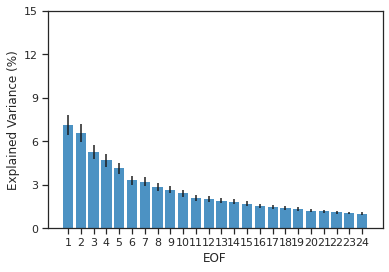

In [19]:
# set seaborn style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# create figure
fig, ax = plt.subplots(figsize=(6,4))

# plot data
xvals = np.arange(neofs) + 1
ax.bar(xvals, pctvar[0:neofs], yerr=err[0:neofs], 
       color='tab:blue', alpha=0.8)

# x-axis
ax.set_xlabel('EOF')
ax.set_xticks(xvals)

# y-axis
ax.set_ylabel('Explained Variance (%)')
yticks = np.arange(0,16,3)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks) 

# save fig
filepath = path_to_figs + 'exp_variance_' + fname_id + '.png'
plt.savefig(filepath, dpi=300)

# show
plt.show()

### Loadings

In [20]:
neofs = 19
loads = loadings(evals, evecs, neofs)

print(loads.shape)
print(np.round(loads,3))

(213, 19)
[[-0.051 -0.113  0.09  ... -0.043 -0.008  0.191]
 [-0.038 -0.012 -0.042 ... -0.071  0.028 -0.029]
 [ 0.387 -0.031  0.141 ...  0.178  0.128 -0.029]
 ...
 [-0.105 -0.441  0.162 ... -0.066  0.094  0.201]
 [-0.211 -0.215  0.012 ... -0.012  0.106  0.163]
 [-0.208 -0.045  0.089 ... -0.036  0.109  0.178]]


### Save EOFs

In [21]:
# Save eigenvalues, eigenvectors, and loadings

neofs = 4   # number of EOFs to save (evecs, loadings3)

outfile = path_to_out + 'eigenvalues_'+ fname_id + '.txt'
np.savetxt(outfile, evals, fmt='%.5f')

outfile = path_to_out + 'eigenvectors_'+ fname_id + '.txt'
np.savetxt(outfile, evecs[:,0:neofs], fmt='%.5f', delimiter=',')

outfile = path_to_out + 'loadings_'+ fname_id + '.txt'
np.savetxt(outfile, loads[:,0:neofs], fmt='%.4f', delimiter=',')


### PCs

In [29]:
# Calculate principal components (spatial modes)
neofs = 19
pcs = calc_pcs(Xs, evecs, neofs, mode=eofmode)

In [31]:
# Split pcs into separate arrays for each variable
ntim, nlat, nlon = var2.shape
npts = nlat*nlon
nvar = len(var_list)
# Reshape spatial dim back to 2D map
pcmodes = var_list
for i in np.arange(len(var_list)):
    tmp = pcs[:,i*npts:(i+1)*npts]
    pcmodes[i] = np.reshape(tmp, (neofs,nlat,nlon))

### Fig 3: Spatial Modes

In [32]:
# Panel Plot of Spatial Modes

# number of eofs to plot
neofs = 4

# Data for plotting extratropics
lons_et = var2.lon.data
lats_et = var2.lat.data
udat_et = pcmodes[0][0:neofs,:,:]
vdat_et = pcmodes[1][0:neofs,:,:]
data_et = pcmodes[2][0:neofs,:,:]

# Data for plotting tropics
lons_t = var4.lon.data
lats_t = var4.lat.data
udat_t = pcmodes[3][0:neofs,:,:]
vdat_t = pcmodes[4][0:neofs,:,:]
data_t = pcmodes[5][0:neofs,:,:]

print(np.nanmin(data_et), np.nanmax(data_et))

# Set up projection
# mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subtitles
eof_label = [ ]
var_label = [ ]
for k in range(neofs):
    eof_label.append("EOF{:1d}".format(k+1,))
    var_label.append("{:.2f}%".format(pctvar[k]))

-2.969897113625506 3.260969157874098


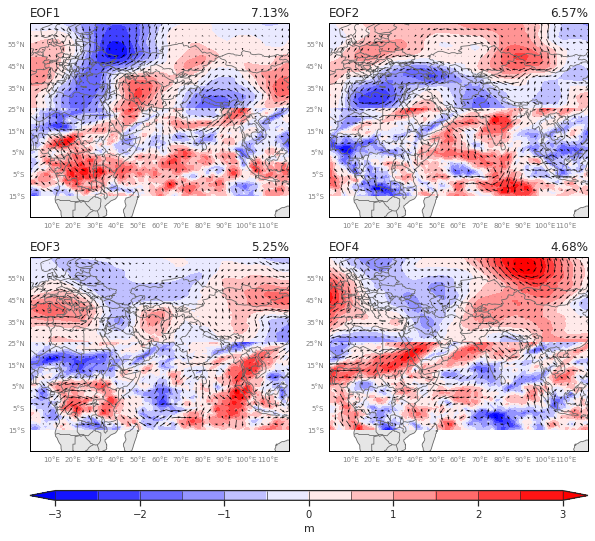

In [34]:
# Create figure
fig = plt.figure(figsize=(10,11))
filepath = path_to_figs + 'eofs_'+ fname_id + '.png'
nrows = 2
ncols = 2
mapcrs = ccrs.PlateCarree()
# sns.set_style('ticks')

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.55,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.0, 
                cbar_size='2.5%',
                label_mode='')

#newcmap = cmocean.tools.crop_by_percent(cmo.matter, 15, which='max', N=None)

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
#     ax = draw_basemap(ax, extent=None, xticks=dx, yticks=dy)
    
    # Add contour fill plot for extratropics
    clevs = np.arange(-3,3.5,.5)
    cf = ax.contourf(lons_et, lats_et, data_et[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    # add vectors for extratropics
    ax.quiver(lons_et, lats_et, udat_et[k,:,:], vdat_et[k,:,:], transform=datacrs,
              color='black', pivot='middle', regrid_shape=30) 
    
    # Add contour fill plot for q500
    cf = ax.contourf(lons_t, lats_t, data_t[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    # add vectors for tropics
    ax.quiver(lons_t, lats_t, udat_t[k,:,:], vdat_t[k,:,:], transform=datacrs,
              color='black', pivot='middle', regrid_shape=30)
    
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k], loc='right', fontsize=12)
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('m', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
fig = plt.figure(figsize=(4.0 ,4.0))
fig.dpi = 300
fname = path_to_figs + 'eofs_'+ fname_id + 'NPS'
fmt = 'png'

for k in np.arange(neofs):
    ax = plt.subplot(2, 2, k+1, projection=mapcrs)
#     ax.set_extent([lons.min(), lons.max(), lats.min(), 90.], crs=mapcrs)
    # Add contour fill plot for h500
    clevs = np.arange(-25,27.5,2.5)
    cf = ax.contourf(lons_et, lats_et, data_et[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    # add vectors for extratropics
    ax.quiver(lons_et, lats_et, udat_et[k,:,:], vdat_et[k,:,:], transform=datacrs,
              color='black', pivot='middle', regrid_shape=30) 
    
    # Add contour fill plot for q500
    cf = ax.contourf(lons_t, lats_t, data_t[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    # add vectors for tropics
    ax.quiver(lons_t, lats_t, udat_t[k,:,:], vdat_t[k,:,:], transform=datacrs,
              color='black', pivot='middle', regrid_shape=30)
    
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k], loc='right', fontsize=12)
    
    ax.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.3)
#     ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.3)

    ## Add in meridian and parallels
    gl = ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--')

#     gl.xlocator = mticker.FixedLocator(np.arange(-180., 200., 20))
#     gl.ylocator = mticker.FixedLocator(np.arange(20., 70., 10.))
#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.yformatter = LATITUDE_FORMATTER
    
# # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.13, 0.05, 0.77, 0.02])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='horizontal', extendfrac='auto')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('m', fontsize=10)

plt.subplots_adjust(hspace=0.3)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))
# plt.show()